In [1]:
import os
import datetime
import random
import csv

import PIL
from PIL import Image
from PIL import ImageEnhance

import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.layers import dropout
from tensorflow.contrib.layers import conv2d
from tensorflow.contrib.layers import variance_scaling_initializer
from tensorflow.contrib.layers import batch_norm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# path to dataset 
DATA_ROOT = r"/run/media/onionhuang/HDD/artificial_intelligence/kaggle/Carvana-Image-Masking-Challenge"
assert(os.path.exists(DATA_ROOT))

TRAIN_IMAGES = os.path.join(DATA_ROOT, "train")
assert(os.path.exists(TRAIN_IMAGES))

TRAIN_MASKS = os.path.join(DATA_ROOT, "train_masks")
assert(os.path.exists(TRAIN_MASKS))

TRAIN_MASKS_CSV = os.path.join(DATA_ROOT, "train_masks.csv")
assert(os.path.exists(TRAIN_MASKS_CSV))

METADATA_CSV = os.path.join(DATA_ROOT, "metadata.csv")
assert(os.path.exists(METADATA_CSV))

TEST_IMAGES = os.path.join(DATA_ROOT, "test")
assert(os.path.exists(TEST_IMAGES))

In [2]:
def get_next_batch(iteration, batch_size, dataset):
    if batch_size * (iteration + 1) > len(dataset):
        return dataset[batch_size*iteration:]
    else:
        return dataset[batch_size*iteration:batch_size*(iteration+1)]

In [3]:
def resize_image_pil(
    image, 
    size, 
    random_enhance=True,
    pad=True, 
    pad_center=True,
    resample_filter=PIL.Image.LANCZOS):
    
    if random_enhance:
        image = random_enhance_pil(image)
    
    width, height = image.size
    
    if height > width:
        new_height = size
        ratio = new_height / height
        new_width = int(width * ratio)
    
    elif width > height:
        new_width = size
        ratio = new_width / width
        new_height = int(height * ratio)
    
    else:
        new_width = size
        new_height = size
        
    image_resize = image.resize((new_width, new_height), resample=resample_filter)
    
#     if random_enhance:
#         image_resize = random_enhance_pil(image_resize)
    
    if pad:
        image_pad = Image.new("RGB", (size, size), (0, 0, 0))
      
        if pad_center:
            ulc = ((size - new_width) // 2, (size - new_height) // 2)
            image_pad.paste(image_resize, ulc)
        else:
            image_pad.paste(image_resize, (0, 0))

        return image_pad
    else:
        return image_resize

In [4]:
BRIGHTNESS_FACTOR_MIN = 0.35
BRIGHTNESS_FACTOR_MAX = 1.5

CONTRAST_FACTOR_MIN = 0.35
CONTRAST_FACTOR_MAX = 2

SHARPENESS_FACTOR_MIN = 0
SHARPENESS_FACTOR_MAX = 2

SATURATION_FACTOR_MIN = 0
SATURATION_FACTOR_MAX = 2

def random_enhance_pil(image, brightness=True, contrast=True, saturation=True, sharpness=True):
    new_image = image
    
    if brightness:
        enhancer = ImageEnhance.Brightness(new_image)
        new_image = enhancer.enhance(random.uniform(BRIGHTNESS_FACTOR_MIN, BRIGHTNESS_FACTOR_MAX))
    
    if contrast:
        enhancer = ImageEnhance.Contrast(new_image)
        new_image = enhancer.enhance(random.uniform(CONTRAST_FACTOR_MIN, CONTRAST_FACTOR_MAX))
    
    if saturation:
        enhancer = ImageEnhance.Color(new_image)
        new_image = enhancer.enhance(random.uniform(SATURATION_FACTOR_MIN, SATURATION_FACTOR_MAX))
    
    if sharpness:
        enhancer = ImageEnhance.Sharpness(new_image)
        new_image = enhancer.enhance(random.uniform(SHARPENESS_FACTOR_MIN, SHARPENESS_FACTOR_MAX))
    
    return new_image

In [5]:
def enhance_sharpness(image, factor):
    enhancer = ImageEnhance.Sharpness(image)
    new_image = enhancer.enhance(factor)
    
    return new_image

def enhance_contrast(image, factor):
    enhancer = ImageEnhance.Contrast(image)
    new_image = enhancer.enhance(factor)
    
    return new_image

In [6]:
def image_to_nparray_pil(image, shape):
    return np.array(image.getdata()).reshape(shape) 

In [7]:
def image_to_float_pil(image):
    return image.astype(float) / 255.0

In [8]:
def random_enhance_tf(image, brightness=True, contrast=True, saturation=True):
    new_image = image
    
    if brightness:
        seed = datetime.datetime.now().second
        new_image = tf.image.random_brightness(new_image, 5, seed=seed)
    
    if contrast:
        seed = datetime.datetime.now().second
        new_image = tf.image.random_contrast(new_image, 0.1, 1.5, seed=seed)
    
    if saturation:
        seed = datetime.datetime.now().second
        new_image = tf.image.random_saturation(new_image, 0., 1.5, seed=seed)
    
    return new_image

def random_flip_tf(image, vertical=True, horizontal=True):
    new_image = image
    
    if vertical:
        seed = datetime.datetime.now().second
        new_image = tf.image.random_flip_up_down(new_image, seed=seed)
    
    if horizontal:
        seed = datetime.datetime.now().second
        new_image = tf.image.random_flip_left_right(new_image, seed=seed)
    
    return new_image

In [9]:
# Global Settings

IMAGE_SIZE = 224 # ImageNet Models Compatibility

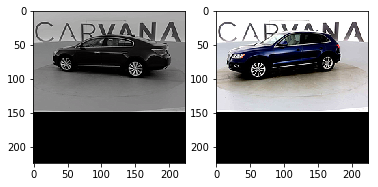

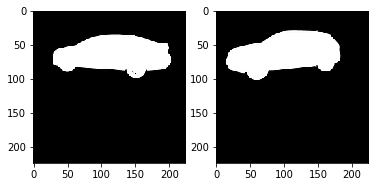

In [10]:
fig = plt.figure()
fig_mask = plt.figure()

files = sorted(os.listdir(TRAIN_IMAGES)[:2])

for index, file in enumerate(files):
    
    img_path = os.path.join(TRAIN_IMAGES, file)
    mask_path = os.path.join(TRAIN_MASKS, os.path.splitext(file)[0]+"_mask.gif")
    
    with Image.open(img_path) as image:
        image = enhance_sharpness(image, 4)
        
        image = resize_image_pil(image, IMAGE_SIZE, random_enhance=True, pad=True, pad_center=False)

        image = enhance_sharpness(image, 2)
        
        image = (image_to_nparray_pil(image, (-1, IMAGE_SIZE, 3)).astype(float)) / 255.0

        y = fig.add_subplot(1, 2, index+1)
        y.imshow(image)
        
    with Image.open(mask_path) as image:
        image = image.convert("RGB")
        image = resize_image_pil(image, IMAGE_SIZE, random_enhance=False, pad=True, pad_center=False)
        
        image = enhance_sharpness(image, 2)
        
        image = (image_to_nparray_pil(image, (-1, IMAGE_SIZE, 3)).astype(float)) / 255.0

        y = fig_mask.add_subplot(1, 2, index+1)
        y.imshow(image)
    
plt.show()

In [11]:
# reference from kaggle competition kernel

def dice_coef(y_true, y_pred):
    y_pred_f = tf.contrib.keras.backend.flatten(y_pred)
    y_true_f = tf.contrib.keras.backend.flatten(y_true)
    
    intersection = tf.contrib.keras.backend.sum(y_true_f * y_pred_f)
    
    smooth = 0.0
    
    return (2.0 * intersection + smooth) / (tf.contrib.keras.backend.sum(y_true_f) + 
                                            tf.contrib.keras.backend.sum(y_pred_f) + smooth)

# def dice_coef_batch(y_true_batch, y_pred_batch, shape=(-1,)):
def dice_coef_batch(y_true_batch, y_pred_batch):
#     y_pred_f = tf.reshape(y_pred_batch, shape)
#     y_true_f = tf.reshape(y_true_batch, shape)

    y_pred_f = tf.contrib.layers.flatten(y_pred_batch)
    y_true_f = tf.contrib.layers.flatten(y_true_batch)
    
    intersection = tf.contrib.keras.backend.sum(tf.multiply(y_true_f, y_pred_f), axis=1)
    
    return (2.0 * intersection) / (tf.contrib.keras.backend.sum(y_true_f, axis=1) + 
                                            tf.contrib.keras.backend.sum(y_pred_f, axis=1))

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.contrib.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def dice_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def mse_error(y_true_batch, y_pred_batch):
    y_pred_f = tf.contrib.layers.flatten(y_pred_batch)
    y_true_f = tf.contrib.layers.flatten(y_true_batch)
    
    difference = tf.subtract(y_true_f, y_pred_f)
    
    return tf.square(difference)

In [12]:
sess = tf.InteractiveSession()
a = tf.convert_to_tensor([[1., 2., 3.], [4., 5., 6.]])
b = tf.convert_to_tensor([[1., 2., 3.], [4., 5., 6.]])

# a_b_sum = tf.contrib.keras.backend.sum(tf.multiply(a, b), axis=1)
a_sum = tf.contrib.keras.backend.sum(a, axis=1)
b_sum = tf.contrib.keras.backend.sum(b, axis=1)

a_b_sum = a_sum + b_sum

a_b_batch = tf.reduce_mean(mse_error(a, b))

print(a_b_batch.eval())

sess.close()

0.0


In [13]:
TRAINING_DATASET = np.random.permutation(
    [os.path.join(TRAIN_IMAGES, i) for i in os.listdir(TRAIN_IMAGES)])

LABEL_DATASET = [
    os.path.join(
        TRAIN_MASKS, 
        os.path.splitext(os.path.basename(i))[0]+"_mask.gif")
    for i in TRAINING_DATASET]

img_01 = tf.convert_to_tensor(
    np.array([
        Image.open(LABEL_DATASET[0]).getdata(),
        Image.open(LABEL_DATASET[1]).getdata(),
    ]).reshape((2, -1)),
    dtype=tf.float32,
)

img_01_max = tf.reduce_max(img_01, axis=1)

img_02 = tf.convert_to_tensor(
    np.array([
        Image.open(LABEL_DATASET[0]).convert("L").getdata(),
        Image.open(LABEL_DATASET[1]).getdata(),
    ]).reshape((2, -1)),
    dtype=tf.float32,
)

img_03 = tf.convert_to_tensor(
    np.ones((
        2, 
        Image.open(LABEL_DATASET[0]).size[0] * Image.open(LABEL_DATASET[0]).size[1])) * 255.0,
    dtype=tf.float32,
)

sess = tf.InteractiveSession()

# print(dice_coef_batch(img_01, img_02).eval())
# print(dice_coef_batch(img_01, img_03).eval())
# print(dice_coef_batch(img_03, img_03).eval())

print(mse_error(img_01, img_02).eval())
print(mse_error(img_01, img_03).eval())
print(mse_error(img_03, img_03).eval())

print(img_01_max.eval())

sess.close()

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 65025.  65025.  65025. ...,  65025.  65025.  65025.]
 [ 65025.  65025.  65025. ...,  65025.  65025.  65025.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[ 1.  1.]


In [14]:
# flip_vertical = tf.placeholder(tf.bool, shape=())
# flip_horizontal = tf.placeholder(tf.bool, shape=()) 

# x = tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE, 3])
# y = tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE, 1])

# layer = x

# layer = tf.cond(
#     flip_vertical,
#     lambda: tf.map_fn(lambda img: tf.image.flip_up_down(img), layer),
#     lambda: layer,
# )

# y = tf.cond(
#     flip_vertical,
#     lambda: tf.map_fn(lambda img: tf.image.flip_up_down(img), y),
#     lambda: y,
# )

# layer = tf.cond(
#     flip_horizontal,
#     lambda: tf.map_fn(lambda img: tf.image.flip_left_right(img), layer),
#     lambda: layer,
# )

# y = tf.cond(
#     flip_horizontal,
#     lambda: tf.map_fn(lambda img: tf.image.flip_left_right(img), y),
#     lambda: y,
# )

# sess = tf.InteractiveSession()

# TRAINING_DATASET = np.random.permutation(
#     [os.path.join(TRAIN_IMAGES, i) for i in os.listdir(TRAIN_IMAGES)])

# x_batch = []

# for file in TRAINING_DATASET[:1]:
#     image = Image.open(file)

#     image = resize_image_pil(image, IMAGE_SIZE, random_enhance=False, pad=True, pad_center=False)

#     x_batch.append(image) 

# x_batch = [image_to_nparray_pil(image, (IMAGE_SIZE, IMAGE_SIZE, 3)) for image in x_batch]

# plt.imshow(layer.eval(feed_dict={
#     x: x_batch,
#     flip_vertical: True,
#     flip_horizontal: True,
# })[0])

# # print(
# #     layer.eval(
# #         feed_dict={
# #             x: x_batch,
# #             flip_vertical: True,
# #             flip_horizontal: True,
# #         }
# #     )
# # )

# plt.show()


# sess.close()

In [15]:
WIDTH = IMAGE_SIZE
HEIGHT = IMAGE_SIZE

n_outputs = IMAGE_SIZE * IMAGE_SIZE

# parameters of convolution layers
n_filters = [175, 175, 175]
n_kernel_size = [7, 5, 3]
n_strides = [2, 2, 2]

# n_filters = [64, 64, 64, 128, 128, 128]
# n_kernel_size = [7, 5, 3, 3, 3, 3]
# n_strides = [1, 1, 1, 2, 2, 2]

# parameters of fully connected layers
keep_prob = 0.75
n_neurons = [2048]

# parameters of optimizer
learning_rate = 0.01

prefix = "convnet_sigmoid_{}".format("01")
# prefix = "perceptron_predict_{}".format("01")

In [ ]:
# tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, HEIGHT, WIDTH, 3])
y = tf.placeholder(tf.float32, [None, HEIGHT, WIDTH, 1])

is_training = tf.placeholder(tf.bool, shape=())

# flip_vertical = tf.placeholder(tf.bool, shape=())
# flip_horizontal = tf.placeholder(tf.bool, shape=()) 

layer = x
label = y

# layer = tf.cond(
#     flip_vertical,
#     lambda: tf.map_fn(lambda img: tf.image.flip_up_down(img), layer),
#     lambda: layer,
# )

# label = tf.cond(
#     flip_vertical,
#     lambda: tf.map_fn(lambda img: tf.image.flip_up_down(img), label),
#     lambda: label,
# )

# layer = tf.cond(
#     flip_horizontal,
#     lambda: tf.map_fn(lambda img: tf.image.flip_left_right(img), layer),
#     lambda: layer,
# )

# label = tf.cond(
#     flip_horizontal,
#     lambda: tf.map_fn(lambda img: tf.image.flip_left_right(img), label),
#     lambda: label,
# )

# layer = tf.map_fn(lambda img: random_enhance_tf(img), layer)
layer = tf.image.convert_image_dtype(layer, tf.float32)

label = tf.image.convert_image_dtype(label, tf.float32) / 255.0

# layer = tf.map_fn(lambda img: tf.image.per_image_standardization(img), layer)
# layer = tf.nn.local_response_normalization(layer)

index = 0
for filters, kernel_size, stride in zip(n_filters, n_kernel_size, n_strides):
    layer = conv2d(
        layer, 
        filters, 
        kernel_size, 
        stride, 
        padding="SAME",
        activation_fn=tf.nn.elu,
        normalizer_fn=batch_norm, # use batch normalization
        normalizer_params={
            "is_training": is_training,
            "decay": 0.99,
            "updates_collections": None,
        },
        weights_initializer=variance_scaling_initializer(), # use he initializer
        scope="{}_conv-{}".format(prefix, index),
    )
    
#     layer = tf.nn.local_response_normalization(layer)
    
    index += 1
    
# layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

layer = tf.nn.avg_pool(
    layer, 
    ksize=[1, 4, 4, 1], 
    strides=[1, 2, 2, 1], 
    padding="SAME", 
    name="{}_avg-pool".format(prefix),
)

layer = tf.contrib.layers.flatten(layer)

layer = dropout(
    layer,
    keep_prob,
    is_training=is_training,
    scope="{}_drop-to-fc".format(prefix),
)
    
index = 0
for neurons in n_neurons:
    layer = fully_connected(
        layer, 
        neurons,
        activation_fn=tf.nn.elu, # use elu activation function
        normalizer_fn=batch_norm, # use batch normalization
        normalizer_params={
            "is_training": is_training,
            "decay": 0.99,
            "updates_collections": None,
        },
        weights_initializer=variance_scaling_initializer(), # use he initializer
        scope="{}_fc-{}".format(prefix, index),
    )
    
    layer = dropout(
        layer,
        keep_prob,
        is_training=is_training,
        scope="{}_drop-{}".format(prefix, index),
    )
    
    index += 1
    
logits = fully_connected(
    layer,
    n_outputs,
    activation_fn=None,
    normalizer_fn=batch_norm, # use batch normalization
    normalizer_params={
        "is_training": True,
        "decay": 0.99,
        "updates_collections": None,
    },
    weights_initializer=variance_scaling_initializer(), # use he initializer
    scope="{}_output".format(prefix),
)

outputs = tf.nn.sigmoid(logits)
outputs_image = tf.reshape(outputs, [-1, IMAGE_SIZE, IMAGE_SIZE, 1])
outputs_summary = tf.summary.image("logits", outputs_image)

# predict = fully_connected(
#     outputs,
#     n_outputs,
#     activation_fn=None,
# #     normalizer_fn=batch_norm, # use batch normalization
# #     normalizer_params={
# #         "is_training": True,
# #         "decay": 0.99,
# #         "updates_collections": None,
# #     },
#     weights_initializer=variance_scaling_initializer(), # use he initializer
#     scope="predict",
# )

predict = tf.rint(outputs)
predict_image = tf.reshape(predict, [-1, IMAGE_SIZE, IMAGE_SIZE, 1])
predict_summary = tf.summary.image("predict", predict_image)

# label_maximum = tf.reduce_max(tf.contrib.layers.flatten(label), axis=1)
label_summary = tf.summary.image("label", label)

loss = tf.reduce_mean(mse_error(label, outputs))
# loss = tf.reduce_mean(mse_error(label, predict), name="loss")

loss_summary = tf.summary.scalar("loss", loss)

# use AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# minimizing the loss in training op
training_op = optimizer.minimize(loss)

# initializer for all variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

now = datetime.datetime.utcnow().strftime("%Y%m%d%H%M%S")
LOG_DIR = "logs/{}/".format(now)

summary_writer = tf.summary.FileWriter(LOG_DIR, tf.get_default_graph())

In [ ]:
n_epochs = 200
batch_size = 10

# runing the graph
with tf.Session() as sess:

    # we need to initialize all variables first
    init.run()
    
#     saver.restore(sess, "./my-convnet.ckpt")

    for epoch in range(n_epochs):
        
#         TRAINING_DATASET = np.random.permutation(
#             [os.path.join(TRAIN_IMAGES, i) for i in os.listdir(TRAIN_IMAGES)])

        TRAINING_DATASET = []
    
        for i in os.listdir(TRAIN_IMAGES):
            if os.path.splitext(i)[0].split("_")[1] == "01":
                TRAINING_DATASET.append(os.path.join(TRAIN_IMAGES, i))
                
        TRAINING_DATASET = np.random.permutation(TRAINING_DATASET)
        
        LABEL_DATASET = [
            os.path.join(
                TRAIN_MASKS, 
                os.path.splitext(os.path.basename(i))[0]+"_mask.gif")
            for i in TRAINING_DATASET]
        
        for iteration in range(len(TRAINING_DATASET) // batch_size):
            
            seed = datetime.datetime.now().second
            
#             flip_v = False
#             flip_h = False
            
#             if seed % 2 == 0:
#                 flip_h = True
#             if seed % 3 == 0:
#                 flip_v = True

            # get mini bath of training data
            next_batch = get_next_batch(
                batch_size=batch_size, 
                iteration=iteration, 
                dataset=TRAINING_DATASET)
            
            x_batch = []
            
            for file in next_batch:
                image = Image.open(file)
#                 image = enhance_sharpness(image, 4)
#                 image = resize_image_pil(image, IMAGE_SIZE, random_enhance=False, pad=True, pad_center=False)
                image = resize_image_pil(image, IMAGE_SIZE, random_enhance=True, pad=True, pad_center=False)
#                 image = enhance_sharpness(image, 2)
                
                x_batch.append(image) 

            x_batch = [image_to_nparray_pil(image, (HEIGHT, WIDTH, 3)) for image in x_batch]
            
            next_batch = get_next_batch(
                batch_size=batch_size, 
                iteration=iteration, 
                dataset=LABEL_DATASET)
            
            y_batch = []
            
            for file in next_batch:
                image = Image.open(file)
                
                image = image.convert("RGB")
                image = resize_image_pil(image, IMAGE_SIZE, random_enhance=False, pad=True, pad_center=False)
#                 image = enhance_sharpness(image, 2)
                image = image.convert("L")
                
                y_batch.append(image)

            y_batch = [image_to_nparray_pil(image, (HEIGHT, WIDTH, 1)) for image in y_batch]

            _, loss_log, outputs_log, predict_log, label_log = sess.run(
                [
                    training_op,
                    loss_summary,
                    outputs_summary,
                    predict_summary, 
                    label_summary,
                ], 
                feed_dict={
                    x: x_batch, 
                    y: y_batch, 
                    is_training: True,
#                     flip_vertical: flip_v,
#                     flip_horizontal: flip_h
                }
            )
    
            step = epoch * (len(TRAINING_DATASET) // batch_size) + iteration
            summary_writer.add_summary(loss_log, step)

            print(epoch, iteration)
            
#             print(label_maximum.eval(
#                 feed_dict={
#                         x: x_batch, 
#                         y: y_batch, 
#                         is_training: False,
#                         flip_vertical: False,
#                         flip_horizontal: True,
#                 }
#             ))
    
            if iteration % 100 == 0:
                saver.save(sess, "./{}/my-convnet.ckpt".format(prefix))
                
            if iteration % 10 == 0:  
                summary_writer.add_summary(predict_log, step)
                summary_writer.add_summary(label_log, step)
                summary_writer.add_summary(outputs_log, step) 

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
5 24
5 25
5 26
5 27
5 28
5 29
5 30
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
6 20
6 21
6 22
6 23
6 24
6 25
6 26
6 27
